

This notebook contains an example for teaching.


# Penalized Linear Regressions: A Simulation Experiment

## Data Generating Process: Approximately Sparse

[1] "theoretical R2:"   "0.826881788964026"


0.8268818


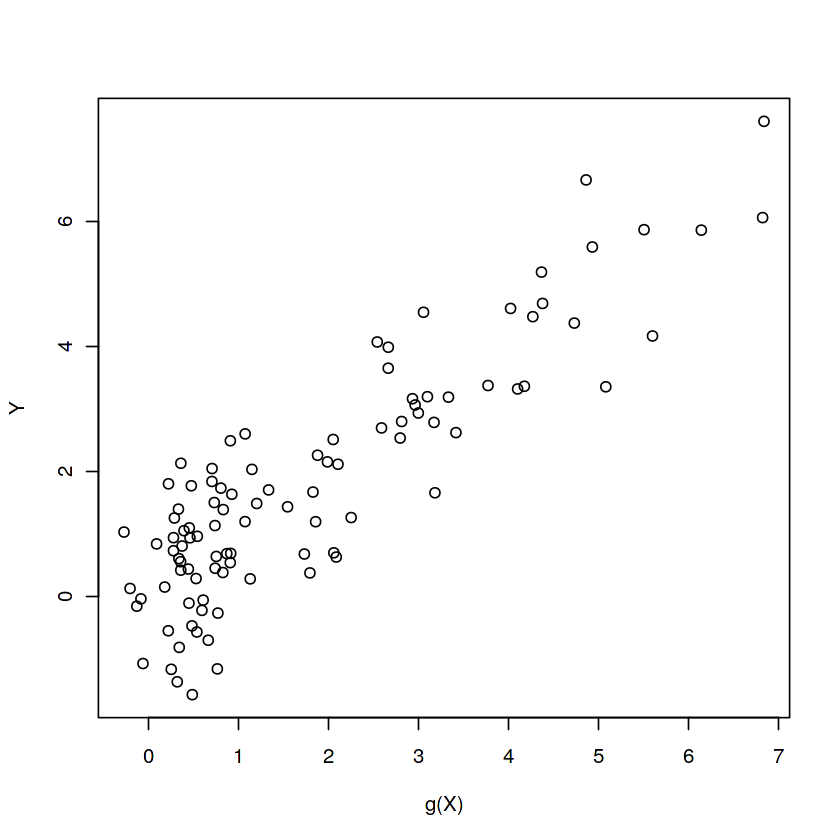

In [1]:
set.seed(1)

n = 100;
p = 400;

Z= runif(n)-1/2;
W = matrix(runif(n*p)-1/2, n, p);



beta = 1/seq(1:p)^2;   # approximately sparse beta
#beta = rnorm(p)*.2    # dense beta
gX = exp(4*Z)+ W%*%beta;  # leading term nonlinear
X = cbind(Z, Z^2, Z^3, W );  # polynomials in Zs will be approximating exp(4*Z)


Y = gX + rnorm(n);    #generate Y


plot(gX,Y, xlab="g(X)", ylab="Y")    #plot V vs g(X)

print( c("theoretical R2:", var(gX)/var(Y)))

var(gX)/var(Y); #theoretical R-square in the simulation example





We use package Glmnet to carry out predictions using cross-validated lasso, ridge, and elastic net

In [2]:

library(glmnet)
fit.lasso.cv   <- cv.glmnet(X, Y, family="gaussian", alpha=1)  # family gaussian means that we'll be using square loss
fit.ridge   <- cv.glmnet(X, Y, family="gaussian", alpha=0)     # family gaussian means that we'll be using square loss
fit.elnet   <- cv.glmnet(X, Y, family="gaussian", alpha=.5)    # family gaussian means that we'll be using square loss

yhat.lasso.cv    <- predict(fit.lasso.cv, newx = X)            # predictions
yhat.ridge   <- predict(fit.ridge, newx = X)
yhat.elnet   <- predict(fit.elnet, newx = X)

MSE.lasso.cv <- summary(lm((gX-yhat.lasso.cv)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)
MSE.ridge <- summary(lm((gX-yhat.ridge)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)
MSE.elnet <- summary(lm((gX-yhat.elnet)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)


Loading required package: Matrix

Loaded glmnet 4.0-2



Here we compute the lasso and ols post lasso using plug-in choices for penalty levels, using package hdm

In [3]:
library(hdm) 
fit.rlasso  <- rlasso(Y~X,  post=FALSE)      # lasso with plug-in penalty level
fit.rlasso.post <- rlasso(Y~X,  post=TRUE)    # post-lasso with plug-in penalty level

yhat.rlasso   <- predict(fit.rlasso)            #predict g(X) for values of X
yhat.rlasso.post   <- predict(fit.rlasso.post)  #predict g(X) for values of X

MSE.lasso <- summary(lm((gX-yhat.rlasso)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)
MSE.lasso.post <- summary(lm((gX-yhat.rlasso.post)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)



Next we code up lava, which alternates the fitting of lasso and ridge

In [4]:
library(glmnet)

lava.predict<- function(X,Y, iter=5){
    
g1 = predict(rlasso(X, Y, post=F))  #lasso step fits "sparse part"
m1 =  predict(glmnet(X, as.vector(Y-g1), family="gaussian", alpha=0, lambda =20),newx=X ) #ridge step fits the "dense" part

    
i=1
while(i<= iter) {
g1 = predict(rlasso(X, as.vector(Y-m1), post=F))   #lasso step fits "sparse part"
m1 = predict(glmnet(X, as.vector(Y-g1), family="gaussian",  alpha=0, lambda =20),newx=X );  #ridge step fits the "dense" part
i = i+1 }

return(g1+m1);
    }


yhat.lava = lava.predict(X,Y)
MSE.lava <- summary(lm((gX-yhat.lava)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)

    
MSE.lava

[1] 0.15896819 0.02568451

In [5]:
library(xtable)
table<- matrix(0, 6, 2)
table[1,1:2]   <- MSE.lasso.cv
table[2,1:2]   <- MSE.ridge
table[3,1:2]   <- MSE.elnet
table[4,1:2]   <- MSE.lasso
table[5,1:2]   <- MSE.lasso.post
table[6,1:2]   <- MSE.lava

colnames(table)<- c("MSA", "S.E. for MSA")
rownames(table)<- c("Cross-Validated Lasso", "Cross-Validated ridge","Cross-Validated elnet",
                    "Lasso","Post-Lasso","Lava")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab



% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Fri Feb 18 13:59:19 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & MSA & S.E. for MSA \\ 
  \hline
Cross-Validated Lasso & 0.367 & 0.061 \\ 
  Cross-Validated ridge & 2.384 & 0.370 \\ 
  Cross-Validated elnet & 0.399 & 0.064 \\ 
  Lasso & 0.148 & 0.027 \\ 
  Post-Lasso & 0.085 & 0.009 \\ 
  Lava & 0.159 & 0.026 \\ 
   \hline
\end{tabular}
\end{table}


,MSA,S.E. for MSA
,<dbl>,<dbl>
Cross-Validated Lasso,0.3666009,0.061279916
Cross-Validated ridge,2.3842559,0.369909988
Cross-Validated elnet,0.3988608,0.063757963
Lasso,0.1482190,0.026705771
Post-Lasso,0.0845236,0.009469643
Lava,0.1589682,0.025684507


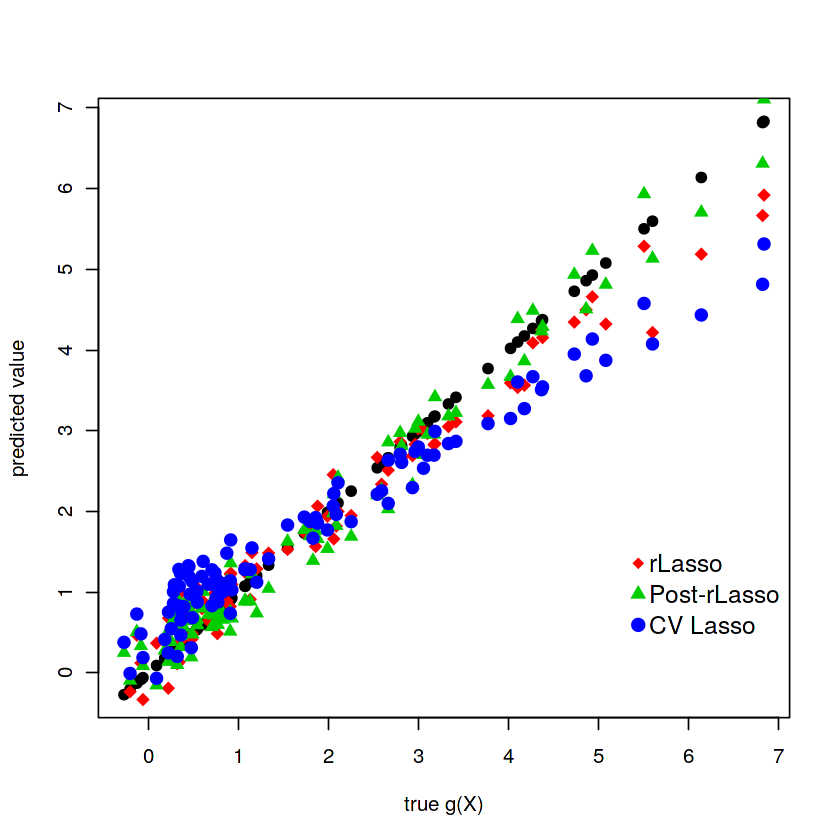

In [6]:

plot(gX, gX, pch=19, cex=1, ylab="predicted value", xlab="true g(X)")

points(gX, yhat.rlasso, col=2, pch=18, cex = 1.5 )
points(gX,  yhat.rlasso.post, col=3, pch=17,  cex = 1.2  )
points( gX, yhat.lasso.cv,col=4, pch=19,  cex = 1.2 )


legend("bottomright", 
  legend = c("rLasso", "Post-rLasso", "CV Lasso"), 
  col = c(2,3,4), 
  pch = c(18,17, 19), 
  bty = "n", 
  pt.cex = 1.3, 
  cex = 1.2, 
  text.col = "black", 
  horiz = F , 
  inset = c(0.1, 0.1))



## Data Generating Process: Approximately Sparse + Small Dense Part

[1] "theoretical R2:"   "0.696687990094227"


0.696688


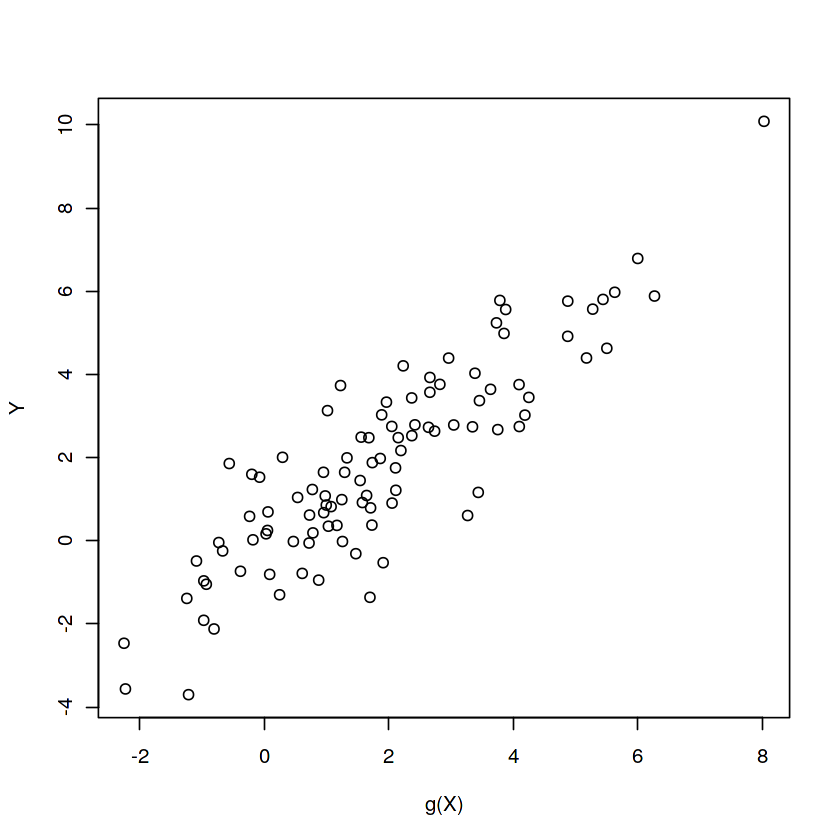

In [7]:
set.seed(1)

n = 100;
p = 400;

Z= runif(n)-1/2;
W = matrix(runif(n*p)-1/2, n, p);


beta = rnorm(p)*.2    # dense beta
gX = exp(4*Z)+ W%*%beta;  # leading term nonlinear
X = cbind(Z, Z^2, Z^3, W );  # polynomials in Zs will be approximating exp(4*Z)


Y = gX + rnorm(n);    #generate Y


plot(gX,Y, xlab="g(X)", ylab="Y")    #plot V vs g(X)

print( c("theoretical R2:", var(gX)/var(Y)))

var(gX)/var(Y); #theoretical R-square in the simulation example




In [8]:

library(glmnet)
fit.lasso.cv   <- cv.glmnet(X, Y, family="gaussian", alpha=1)  # family gaussian means that we'll be using square loss
fit.ridge   <- cv.glmnet(X, Y, family="gaussian", alpha=0)     # family gaussian means that we'll be using square loss
fit.elnet   <- cv.glmnet(X, Y, family="gaussian", alpha=.5)    # family gaussian means that we'll be using square loss

yhat.lasso.cv    <- predict(fit.lasso.cv, newx = X)            # predictions
yhat.ridge   <- predict(fit.ridge, newx = X)
yhat.elnet   <- predict(fit.elnet, newx = X)

MSE.lasso.cv <- summary(lm((gX-yhat.lasso.cv)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)
MSE.ridge <- summary(lm((gX-yhat.ridge)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)
MSE.elnet <- summary(lm((gX-yhat.elnet)^2~1))$coef[1:2]        # report MSE and standard error for MSE for approximating g(X)


In [9]:
library(hdm) 
fit.rlasso  <- rlasso(Y~X,  post=FALSE)      # lasso with plug-in penalty level
fit.rlasso.post <- rlasso(Y~X,  post=TRUE)    # post-lasso with plug-in penalty level

yhat.rlasso   <- predict(fit.rlasso)            #predict g(X) for values of X
yhat.rlasso.post   <- predict(fit.rlasso.post)  #predict g(X) for values of X

MSE.lasso <- summary(lm((gX-yhat.rlasso)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)
MSE.lasso.post <- summary(lm((gX-yhat.rlasso.post)^2~1))$coef[1:2]  # report MSE and standard error for MSE for approximating g(X)



In [10]:
library(glmnet)

lava.predict<- function(X,Y, iter=5){
    
g1 = predict(rlasso(X, Y, post=F))  #lasso step fits "sparse part"
m1 =  predict(glmnet(X, as.vector(Y-g1), family="gaussian", alpha=0, lambda =20),newx=X ) #ridge step fits the "dense" part

    
i=1
while(i<= iter) {
g1 = predict(rlasso(X, as.vector(Y-m1), post=F))   #lasso step fits "sparse part"
m1 = predict(glmnet(X, as.vector(Y-g1), family="gaussian",  alpha=0, lambda =20),newx=X );  #ridge step fits the "dense" part
i = i+1 }

return(g1+m1);
    }


yhat.lava = lava.predict(X,Y)
MSE.lava <- summary(lm((gX-yhat.lava)^2~1))$coef[1:2]       # report MSE and standard error for MSE for approximating g(X)

    
MSE.lava

[1] 0.67971473 0.07374968

In [11]:
library(xtable)
table<- matrix(0, 6, 2)
table[1,1:2]   <- MSE.lasso.cv
table[2,1:2]   <- MSE.ridge
table[3,1:2]   <- MSE.elnet
table[4,1:2]   <- MSE.lasso
table[5,1:2]   <- MSE.lasso.post
table[6,1:2]   <- MSE.lava

colnames(table)<- c("MSA", "S.E. for MSA")
rownames(table)<- c("Cross-Validated Lasso", "Cross-Validated ridge","Cross-Validated elnet",
                    "Lasso","Post-Lasso","Lava")
tab <- xtable(table, digits =3)
print(tab,type="latex") # set type="latex" for printing table in LaTeX
tab


% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Fri Feb 18 14:00:30 2022
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & MSA & S.E. for MSA \\ 
  \hline
Cross-Validated Lasso & 1.932 & 0.291 \\ 
  Cross-Validated ridge & 3.411 & 0.494 \\ 
  Cross-Validated elnet & 1.825 & 0.252 \\ 
  Lasso & 0.964 & 0.120 \\ 
  Post-Lasso & 1.597 & 0.207 \\ 
  Lava & 0.680 & 0.074 \\ 
   \hline
\end{tabular}
\end{table}


,MSA,S.E. for MSA
,<dbl>,<dbl>
Cross-Validated Lasso,1.9318225,0.29130485
Cross-Validated ridge,3.4106685,0.49426500
Cross-Validated elnet,1.8251591,0.25189955
Lasso,0.9641151,0.11978038
Post-Lasso,1.5966018,0.20707956
Lava,0.6797147,0.07374968


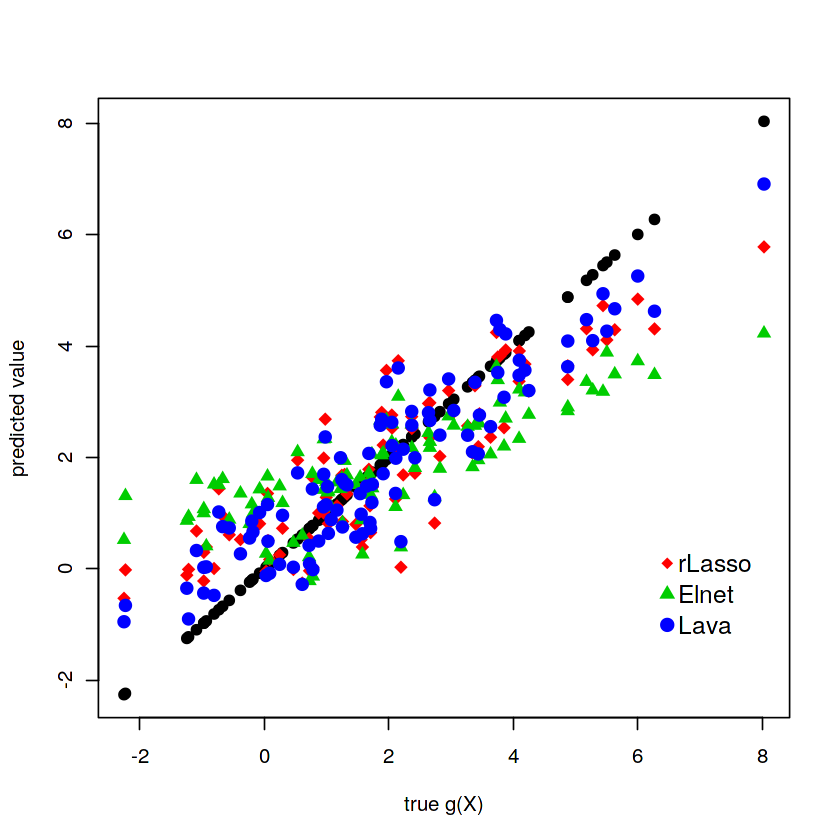

In [12]:

plot(gX, gX, pch=19, cex=1, ylab="predicted value", xlab="true g(X)")

points(gX, yhat.rlasso,   col=2, pch=18, cex = 1.5 )
points(gX, yhat.elnet,  col=3, pch=17,  cex = 1.2  )
points(gX, yhat.lava,  col=4, pch=19,  cex = 1.2 )


legend("bottomright", 
  legend = c("rLasso", "Elnet", "Lava"), 
  col = c(2,3,4), 
  pch = c(18,17, 19), 
  bty = "n", 
  pt.cex = 1.3, 
  cex = 1.2, 
  text.col = "black", 
  horiz = F , 
  inset = c(0.1, 0.1))
